In [71]:
import os
import json
import pandas as pd
import sys
import numpy as np

from sklearn.linear_model import Ridge, LogisticRegression, LinearRegression
from pathlib import Path


repo_root = Path.cwd().parent.parent
sys.path.insert(0, str(repo_root))

from will_replication.my_utils.utils import load_probe_data

In [72]:
def sigmoid_np(x):
    x = np.asarray(x)
    return 1.0 / (1.0 + np.exp(-x))

In [24]:
# MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
DATA_PATH="../../will_replication/probe_results/DATA/SR_DATA"
MODEL_NAME = "Qwen/Qwen2.5-Math-1.5B-Instruct"
LARGE_MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
K=50
TEMPERATURE=0.6


small_model_probe_data = load_probe_data(MODEL_NAME=MODEL_NAME, PROBING_DATASET="MATH", K=K, TEMPERATURE=TEMPERATURE, DATA_PATH=DATA_PATH)
large_model_probe_data = load_probe_data(MODEL_NAME=LARGE_MODEL_NAME, PROBING_DATASET="MATH", K=K, TEMPERATURE=TEMPERATURE, DATA_PATH=DATA_PATH)

In [ ]:
# DATASETS = ["opencompass/AIME2025","gneubig/aime-1983-2024", "DigitalLearningGmbH/MATH-lighteval", "openai/gsm8k"]
DATASET_NAME = "gneubig/aime-1983-2024"
DATASET_NAME = "_".join(DATASET_NAME.split("/"))

In [ ]:
# USE Small probe to predict bigger probes performance.
SMALL_PROBE_PREDICTIONS_PATH = f"../../will_replication/probe_results/DATA/Labelled_SR/MATH_probe/{DATASET_NAME}/{MODEL_ALIAS}_maxlen_3000_k_{K}_temp_{TEMPERATURE}/scored.parquet"
small_labelled_df = pd.read_parquet(SMALL_PROBE_PREDICTIONS_PATH)

MODEL_NAME = "Qwen/Qwen2.5-Math-7B-Instruct"
MODEL_ALIAS = "-".join(MODEL_NAME.split("/"))
LARGE_PROBE_PREDICTIONS_PATH = f"../../will_replication/probe_results/DATA/Labelled_SR/MATH_probe/{DATASET_NAME}/{MODEL_ALIAS}_maxlen_3000_k_{K}_temp_{TEMPERATURE}/scored.parquet"
large_labelled_df = pd.read_parquet(LARGE_PROBE_PREDICTIONS_PATH)

In [13]:
COLS_OF_INTEREST = ["score", "score_raw", "calibrated_score", "calibrated_raw_score"]
small_subset_df = small_labelled_df[COLS_OF_INTEREST]
small_subset_df = small_subset_df.rename(columns={col: f"{col}_1p5" for col in COLS_OF_INTEREST})
large_susbet_df = large_labelled_df[COLS_OF_INTEREST]
large_susbet_df = large_susbet_df.rename(columns={col: f"{col}_7b" for col in COLS_OF_INTEREST})

In [34]:
small_model_probe_data["avg_benchmark_score"]

0.724508000317961

In [66]:
small_a = small_model_probe_data["calibrated_probe"]["platt_a"]
small_b = small_model_probe_data["calibrated_probe"]["platt_b"]
large_a = large_model_probe_data["calibrated_probe"]["platt_a"]
large_b = large_model_probe_data["calibrated_probe"]["platt_b"]

In [ ]:
small_test_preds = small_model_probe_data["test_predictions"] * small_a
small_test_actual = small_model_probe_data["test_actual"]

large_test_preds = large_model_probe_data["test_predictions"]
large_test_actual = large_model_probe_data["test_actual"]

test_preds_df = pd.DataFrame({
    "pred_score_1p5": small_test_preds,
    "test_actual_1p5": small_test_actual,
    "pred_score_7b": large_test_preds,
    "test_actual_7b": large_test_actual
})
test_preds_df.head()

,pred_score_1p5,test_actual_1p5,pred_score_7b,test_actual_7b
0,0.999765,1.00,0.999966,1.00
1,1.064178,1.00,1.040394,1.00
2,0.880232,0.84,0.842896,0.90
3,1.090809,1.00,0.955862,0.98
4,1.034485,1.00,1.001038,1.00


In [73]:
test_preds_df["calibrated_raw_pred_score_1p5"] = (test_preds_df["pred_score_1p5"] * small_a) + small_b
test_preds_df["calibrated_raw_pred_score_7b"] = (test_preds_df["pred_score_7b"] * large_a) + large_b

test_preds_df["sigmoid_calibrated_pred_score_1p5"] = sigmoid_np(test_preds_df["calibrated_raw_pred_score_1p5"])
test_preds_df["sigmoid_calibrated_pred_score_7b"] = sigmoid_np(test_preds_df["calibrated_raw_pred_score_7b"])

In [74]:
test_preds_df["score_bin"] = pd.qcut(test_preds_df["pred_score_1p5"], q=10, duplicates="drop")

test_preds_df

,pred_score_1p5,test_actual_1p5,pred_score_7b,test_actual_7b,score_bin,calibrated_raw_score_1p5,calibrated_raw_score_7b,calibrated_raw_pred_score_1p5,calibrated_raw_pred_score_7b,sigmoid_calibrated_pred_score_1p5,sigmoid_calibrated_pred_score_7b
0,0.999765,1.00,0.999966,1.00,"(0.974, 1.019]",3.501433,3.416449,3.501433,3.416449,0.970729,0.968215
1,1.064178,1.00,1.040394,1.00,"(1.019, 1.191]",3.973912,3.706645,3.973912,3.706645,0.981547,0.976029
2,0.880232,0.84,0.842896,0.90,"(0.838, 0.889]",2.624632,2.288999,2.624632,2.288999,0.932430,0.907962
3,1.090809,1.00,0.955862,0.98,"(1.019, 1.191]",4.169260,3.099874,4.169260,3.099874,0.984772,0.956888
4,1.034485,1.00,1.001038,1.00,"(1.019, 1.191]",3.756113,3.424142,3.756113,3.424142,0.977159,0.968451
...,...,...,...,...,...,...,...,...,...,...,...
4995,0.793285,0.98,0.871497,0.98,"(0.774, 0.838]",1.986863,2.494301,1.986863,2.494301,0.879411,0.923741
4996,0.645763,0.48,0.654064,0.70,"(0.603, 0.702]",0.904761,0.933565,0.904761,0.933565,0.711927,0.717798
4997,0.940984,0.54,0.995565,0.72,"(0.932, 0.974]",3.070265,3.384858,3.070265,3.384858,0.955649,0.967228
4998,0.685175,0.06,0.681631,0.22,"(0.603, 0.702]",1.193854,1.131443,1.193854,1.131443,0.767430,0.756105


In [29]:
grouped = test_preds_df.groupby("score_bin").agg(
    mean_score_1p5=("pred_score_1p5", "mean"),
    acc_1p5=("test_actual_1p5", "mean"),
    acc_7b=("test_actual_7b", "mean"),
    count=("test_actual_7b", "size"),
).reset_index()
grouped

/tmp/ipykernel_1392733/1221733906.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = test_preds_df.groupby("score_bin").agg(


,score_bin,mean_score_1p5,acc_1p5,acc_7b,count
0,"(0.00253, 0.478]",0.364963,0.20620,0.32400,500
1,"(0.478, 0.603]",0.542508,0.35116,0.50212,500
2,"(0.603, 0.702]",0.654943,0.52744,0.65720,500
3,"(0.702, 0.774]",0.738721,0.71096,0.80712,500
4,"(0.774, 0.838]",0.806669,0.80416,0.85336,500
5,"(0.838, 0.889]",0.863701,0.86484,0.89840,500
6,"(0.889, 0.932]",0.910403,0.89556,0.91584,500
7,"(0.932, 0.974]",0.952973,0.93620,0.94668,500
8,"(0.974, 1.019]",0.995560,0.96780,0.97592,500
9,"(1.019, 1.191]",1.055654,0.98076,0.98440,500


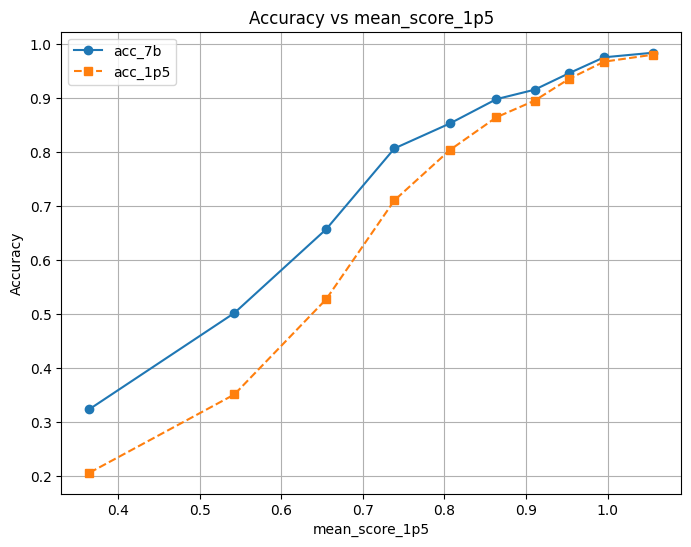

In [75]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(grouped["mean_score_1p5"], grouped["acc_7b"], marker='o', label="acc_7b")
plt.plot(grouped["mean_score_1p5"], grouped["acc_1p5"], marker='s', label="acc_1p5", linestyle='--')
plt.xlabel("mean_score_1p5")
plt.ylabel("Accuracy")
plt.title("Accuracy vs mean_score_1p5")
plt.legend()
plt.grid(True)
plt.show()

# what problems can a small probe predict in the larger probe 

In [ ]:
grouped["delta_7b_minus_1p5"] = grouped["acc_7b"] - grouped["acc_1p5"]
grouped #tells us wher 7b helps the most conditional on what 1.5b thinks. 

,score_bin,mean_score_1p5,acc_1p5,acc_7b,count,delta_7b_minus_1p5
0,"(0.00253, 0.478]",0.364963,0.20620,0.32400,500,0.11780
1,"(0.478, 0.603]",0.542508,0.35116,0.50212,500,0.15096
2,"(0.603, 0.702]",0.654943,0.52744,0.65720,500,0.12976
3,"(0.702, 0.774]",0.738721,0.71096,0.80712,500,0.09616
4,"(0.774, 0.838]",0.806669,0.80416,0.85336,500,0.04920
5,"(0.838, 0.889]",0.863701,0.86484,0.89840,500,0.03356
6,"(0.889, 0.932]",0.910403,0.89556,0.91584,500,0.02028
7,"(0.932, 0.974]",0.952973,0.93620,0.94668,500,0.01048
8,"(0.974, 1.019]",0.995560,0.96780,0.97592,500,0.00812
9,"(1.019, 1.191]",1.055654,0.98076,0.98440,500,0.00364


In [94]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
from scipy.stats import spearmanr

X = test_preds_df[["pred_score_1p5"]].values
y_7b = test_preds_df["test_actual_7b"].values
y_1p5 = test_preds_df["test_actual_1p5"].values

X_train, X_test, y_7b_train, y_7b_test, y_1p5_train, y_1p5_test = train_test_split(
    X, y_7b, y_1p5, test_size=0.4, random_state=42
)


logit_7b = LinearRegression().fit(X_train, y_7b_train)
logit_1p5b = LinearRegression().fit(X_train, y_1p5_train)

train_preds_7b = logit_7b.predict(X_train)
train_mae = mean_absolute_error(y_7b_train, train_preds_7b)
print(f"predicting 7b from 1p5 Train MAE Loss: {train_mae}")

predicting 7b from 1p5 Train MAE Loss: 0.19274824470785673


In [95]:
test_preds_7b = logit_7b.predict(X_test)
test_mae = mean_absolute_error(y_7b_test, test_preds_7b)
print(f"predicting 7b from 1p5 test MAE Loss: {test_mae}")

predicting 7b from 1p5 test MAE Loss: 0.19703338976747647


In [96]:
spearmanr(y_7b_test, test_preds_7b)

SignificanceResult(statistic=0.6606652423434225, pvalue=3.898148351008302e-251)

In [97]:
train_preds_1p5b = logit_1p5b.predict(X_train)
train_mae = mean_absolute_error(y_1p5_train, train_preds_1p5b)
print(f"predicting 1p5b from 1p5b Train MAE Loss: {train_mae}")

predicting 1p5b from 1p5b Train MAE Loss: 0.20436752930672608


In [98]:
test_preds_1p5b = logit_1p5b.predict(X_test)
test_mae = mean_absolute_error(y_1p5_test, test_preds_1p5b)
print(f"predicting 1p5b from 1p5b test MAE Loss: {test_mae}")

predicting 1p5b from 1p5b test MAE Loss: 0.20497083063594665


In [108]:
logit_7b = Ridge(alpha=0.0001).fit(X_train, y_7b_train)
logit_1p5b = Ridge(alpha=0.0001).fit(X_train, y_1p5_train)

train_preds_7b = logit_7b.predict(X_train)
train_mae = mean_absolute_error(y_7b_train, train_preds_7b)
print(f"predicting 7b from 1p5 Train MAE Loss: {train_mae}")

predicting 7b from 1p5 Train MAE Loss: 0.1927482492360126


In [111]:
test_preds_7b = logit_7b.predict(X_test)
test_mae = mean_absolute_error(y_7b_test, test_preds_7b)
print(f"predicting 7b from 1p5 test MAE Loss: {test_mae}")

print(f"Spearman:")
spearmanr(y_7b_test, test_preds_7b)

predicting 7b from 1p5 test MAE Loss: 0.19703339917590243
Spearman:


SignificanceResult(statistic=0.6606652423434225, pvalue=3.898148351008302e-251)